# Detección de los dígitos del medidor

Declaración de librerías.

In [5]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os
import cv2
import pandas as pd

plt.style.use('seaborn-bright')

# Función para obtener dataset. 

De esta función se obtiene la informacion que se utilizara para entrenar la red neuronal. Es una combinacion de dos datasets, el primero siendo `The MNIST DATASET` fuente: http://yann.lecun.com/exdb/mnist/, y la segunda se obtuvo de un dataset creado especialmente para los numeros encontrados en un medidor de agua, https://www.sciencedirect.com/science/article/pii/S2590005621000047, este segundo dataset se tuvo que convertir al mismo formato utilizando la herramienta https://github.com/Arlen0615/Convert-own-data-to-MNIST-format 

In [6]:
def getDataset(test_size = 0.1):
    labels_path = os.path.join('digits-dataset-MR-AMR', 'train-labels-idx1-ubyte')
    images_path = os.path.join('digits-dataset-MR-AMR', 'train-images-idx3-ubyte')
    labels_path2 = os.path.join('digits-dataset', 'train-labels-idx1-ubyte')
    images_path2 = os.path.join('digits-dataset', 'train-images-idx3-ubyte')

    with open(labels_path,'rb') as lbpath, open(labels_path2, 'rb') as lbpath2:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
        labels2 = np.frombuffer(lbpath2.read(), dtype=np.uint8, offset=8)

            
    with open(images_path,'rb') as imgpath, open(images_path2, 'rb') as imgpath2:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        images2 = np.frombuffer(imgpath2.read(), dtype=np.uint8, offset=16).reshape(len(labels2), 784)

    labels = np.concatenate((labels, labels2))
    images = np.concatenate((images, images2))
    print('images', images.shape)
    print('labels', labels.shape)

    k = 10 #number of classes
    img_norm = images / 255
    return train_test_split(img_norm, labels, test_size = test_size, random_state = 1), images, labels



## Se muestran ejemplos aleatorios de la combinación de datasets

images (200000, 784)
labels (200000,)


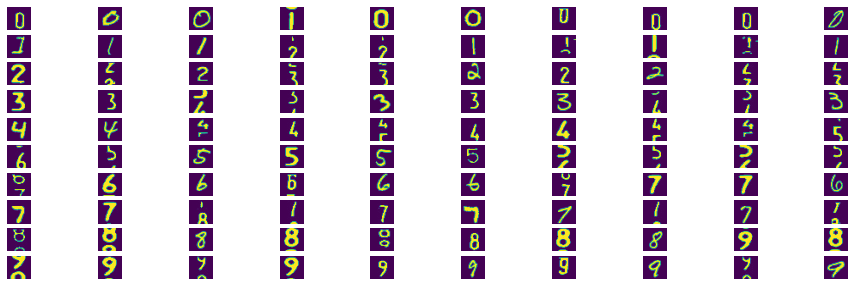

In [7]:
(X_train, X_test, y_train, y_test), images, labels = getDataset()

cols = 10
rows = 10
fig, axs = plt.subplots(rows, cols, figsize=(16, 5))
for i in range(rows):
    img = 0
    l = np.nonzero(labels == i)
    for j in np.random.choice(l[0], cols):
        axs[i, img].axis('off')
        hm = images[j, :].reshape(28, 28)
        axs[i, img].imshow(hm.astype(np.uint8))
        img += 1

Se utilizarons las siguientes funciones de activación:
* `Relu`: Está función es la más utilizada debido a que permite el aprendizaje muy rápido en las redes neuronales. Si a esta función se le da valores de entrada muy negativos el resultado es cero pero si se le da valores positivos queda igual y además el gradiente de esta función será cero en el segundo cuadrante y uno en el primer cuadrante. 
* `Softmax`: Softmax se usa para clases múltiples y cuando se va a asignar probabilidades a cada clase que pertenezca a clases múltiples.
* `Tanh`: La ventaja es que las entradas negativas se mapearán fuertemente negativas y las entradas cero se mapearán cerca de cero.


In [8]:
def softmax(z):
    """
    Z is XW.T = (m,k)
    """
    ex = np.exp(z - np.max(z, axis=1, keepdims=True))
    return ex / ex.sum(axis=1, keepdims=True)

def sigma(z, activation):
    if activation == 'softmax':
        out = softmax(z)
    elif activation == 'tanh':
        out = np.tanh(z)
    else:
        out = z * (z > 0)
    return out

def d_sigma(a, activation):
    if activation == 'tanh':
        out = 1 - a**2
    elif activation == 'softmax':
        out = a * (1 - a)
    else:
        out = 1.*(a > 0)
    return out

## Declaración de funciones para realizar predicciones y calcular la precisión del entrenamiento. 

In [9]:
def predict(A):
    return np.argmax(A, axis = 1)
def accuracy(A, y):
    y_hat = predict(A)
    tptn = sum(y_hat == y)
    return tptn / y.shape[0]

In [10]:
def cost(A, y):
    m = y.shape[0]
    E = -np.log(A[range(m), y])
    return np.sum(E) / m

## Clase para crear una estructura de datos que permite agregar capas ocultas de forma dinámica

In [11]:
class neural_layer():
    def __init__(self, n_conn, n_neur, act_f):
        self.act_f = act_f
        self.b = np.zeros(shape=(1, n_neur))
        self.W = np.random.randn(n_conn, n_neur) * np.sqrt(2 / (n_conn + n_neur)).astype(np.longdouble)


## Función para crear red neuronal, recive como parametro la topologia de la red y la función de activación que utilizara. 
Un ejemplo de una topología es `[784, 4, 5, 10]`, en el contexto de este dataset, la red tiene que empezar con 784 ya que son los features, `4` y `5` serian dos capas ocultas y el numero representa la cantidad de neuronas por capa, el `10` al final, representa la capa de salida, en este caso se necesitan 10 para poder clasificar los dígitos.

In [12]:
def create_nn(topology, act_f):
    nn = []
    for l, layer in enumerate(topology[:-1]):
        nn.append(neural_layer(topology[l], topology[l+1], act_f))
    return nn

## Implementación de función feed forward.  
Esta función va guardando los resultados en de las `A` y `Z` en la variable `out` el cual se va calculando con cada capa encontrada en la red neuronal.

In [13]:
def forward2(neural_net, X):
    out = [(None, X)] # [(Z1, A1), (Z2, A2), ..., (ZN, AN)]
    for l, layer in enumerate(neural_net):
        x = out[-1][1] # A from last output
        z = x @ neural_net[l].W + neural_net[l].b

        if l + 1 == len(neural_net): # if it's last layer, use softmax
            a = sigma(z, 'softmax')
            out.append((z, a))
        else:
            a = sigma(z, neural_net[l].act_f)
            out.append((z, a))
    return out

## Implementación de función de entrenamiento. 
En esta implementación no se separo la función para realizar la propagación del error hacia atrás o `backward propagation` para no perder la referencia sobre la red neuronal.

In [14]:
def train(topology, activation, X, Y, alpha, lmbda, epochs):
    neural_net = create_nn(topology, activation)
    print("##############")
    J = {}

    for i in range(epochs):
        out = forward2(neural_net, X)
        J[i] = cost(out[-1][1], Y)
        derivatives = [] # [(db, dW)]
        deltas = []
        # backward
        for l in reversed(range(0, len(neural_net))):
            z = out[l][0]
            a = out[l][1]
            _a = out[l+1][1]
            m = a.shape[0]
            if l == len(neural_net) - 1:
                _a[range(a.shape[0]), Y] -= 1
                _delta = _a / m
                dW = np.dot(_delta.T, a)
                db = np.sum(_delta, axis=0, keepdims=True).T
                delta = d_sigma(a,neural_net[l].act_f) * np.dot(_delta, neural_net[l].W.T)
                derivatives.insert(0, (db, dW))
                deltas.insert(0, delta)
                
            else:            
                dW2 = np.dot(deltas[0].T, a)
                db2 = np.sum(deltas[0], axis=0, keepdims=True).T
                delta = d_sigma(a,neural_net[l].act_f) * np.dot(deltas[0], dW2)
                derivatives.insert(0, (db2, dW2))
                deltas.insert(0, delta)

            neural_net[l].W = neural_net[l].W - alpha * (derivatives[0][1].T + lmbda / m * neural_net[l].W)
            neural_net[l].b = neural_net[l].b - alpha * derivatives[0][0].T
    
        if i % 10 == 0:
            print('epoch ', i, 'cost ', J[i])

    print('Final cost', J[epochs-1])
    return neural_net, J

Se realiza prueba aleatoria con el método de entrenamiento.

images (200000, 784)
labels (200000,)
##############
epoch  0 cost  2.449773358183255
epoch  10 cost  1.9024452594401218
epoch  20 cost  1.669208359740315
epoch  30 cost  1.5253521772729939
epoch  40 cost  1.4226660525229928
Final cost 1.3504466732871603
Elapsed time 3.3990437825520834 minutes
Accuracy 0.6255388888888889


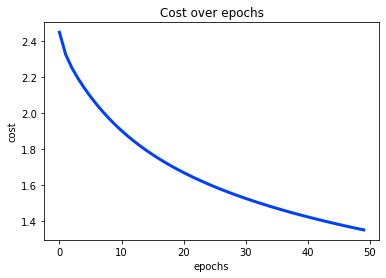

In [15]:
(X_train, X_test, y_train, y_test), images, labels = getDataset()
topology = [X_train.shape[1], 100, 10]
activation = 'tanh'
alpha = 0.1 # 0.5
lmbda = 0.3
epochs = 50
start = time.time()
trained_nn, J = train(topology, activation, X_train, y_train, alpha, lmbda, epochs)
end = time.time()
print('Elapsed time', (end - start)/60, 'minutes')
A = forward2(trained_nn, X_train)
acc = accuracy(A[-1][1], y_train)
print('Accuracy', acc)
plt.plot(list(J.keys()), list(J.values()), linewidth=3)
plt.title('Cost over epochs')
plt.xlabel('epochs')
plt.ylabel('cost');

## Implementación del gradiente descendiente estocástico con mini batches

In [16]:
def minibatch(x, y, size):
    np.random.seed(2)
    m, n = x.shape
    idxs = np.arange(m)
    np.random.shuffle(idxs)
    for idx in range(0, m - size + 1, size):
        batch = idxs[idx: idx + size]
        yield x[batch], y[batch]

In [17]:
def SGD_batch(topology, activation, X, Y, alpha, lmbda, epochs, batch_size):
    neural_net = create_nn(topology, activation)
    print("##############")
    J = {}

    for i in range(epochs):
        out = forward2(neural_net, X)
        J[i] = cost(out[-1][1], Y)

        for batch in minibatch(X, Y, size = batch_size):
            a1, y_batch = batch
            out = forward2(neural_net, a1)
            derivatives = [] # [(db, dW)]
            deltas = []
            for l in reversed(range(0, len(neural_net))):
                z = out[l][0]
                a = out[l][1]
                _a = out[l+1][1]
                m = a.shape[0]
                if l == len(neural_net) - 1:
                    _a[range(a.shape[0]), y_batch] -= 1
                    _delta = _a / m
                    dW = np.dot(_delta.T, a)
                    db = np.sum(_delta, axis=0, keepdims=True).T
                    delta = d_sigma(a,neural_net[l].act_f) * np.dot(_delta, neural_net[l].W.T)
                    derivatives.insert(0, (db, dW))
                    deltas.insert(0, delta)
                    
                else:            
                    dW2 = np.dot(deltas[0].T, a)
                    db2 = np.sum(deltas[0], axis=0, keepdims=True).T
                    delta = d_sigma(a,neural_net[l].act_f) * np.dot(deltas[0], dW2)
                    derivatives.insert(0, (db2, dW2))
                    deltas.insert(0, delta)

                neural_net[l].W = neural_net[l].W - alpha * (derivatives[0][1].T + lmbda / batch_size * neural_net[l].W)
                neural_net[l].b = neural_net[l].b - alpha * derivatives[0][0].T
    
        if i % 10 == 0:
            print('epoch ', i, 'cost ', J[i])

    print('Final cost', J[epochs-1])
    return neural_net, J

Prueba con el gradiente descendiente estocástico utilizando los híper parámetros encontrados en el random grid search

##############
epoch  0 cost  2.4531364178584254
epoch  10 cost  0.12186275473306502
epoch  20 cost  0.12011442116967036
epoch  30 cost  0.1185779035642932
epoch  40 cost  0.1160386318068669
epoch  50 cost  0.11669327115930787
Final cost 0.11631552977104691
Elapsed time 4.603597867488861 minutes
Accuracy 0.98105


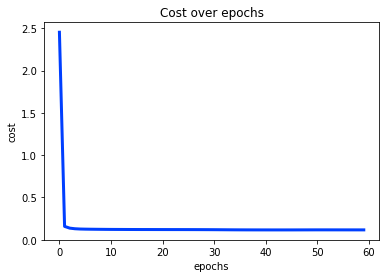

In [18]:
# [784 100 10]	tanh	0.69	0.1	50	70
# [784 60 10]	relu	0.03	0.1	60	90
# [784 60 10]	tanh	0.24	0.1	60	60

topology = [X_train.shape[1], 60, 10]
activation = 'tanh'
alpha = 0.24 # 0.5
lmbda = 0.1
epochs = 60
batch_size = 60
start = time.time()
trained_nn, J = SGD_batch(topology, activation, X_train, y_train, alpha, lmbda, epochs, batch_size)
end = time.time()
print('Elapsed time', (end - start)/60, 'minutes')
A = forward2(trained_nn, X_train)
acc = accuracy(A[-1][1], y_train)
print('Accuracy', acc)
plt.plot(list(J.keys()), list(J.values()), linewidth=3)
plt.title('Cost over epochs')
plt.xlabel('epochs')
plt.ylabel('cost');

Precisión de la red neuronal utilizando el set de datos para pruebas

In [24]:
A = forward2(trained_nn, X_test)
acc = accuracy(A[-1][1], y_test)
print('Accuracy over tests', acc)

Accuracy over tests 0.9802


Métodos para visualizar la matriz de confusión

In [25]:
def confusion_matrix(A, y):
    k = A.shape[1]
    mat = np.zeros((k, k))
    y_hat = predict(A)
    for i in range(k):
        T = (y_hat == i) #all equal to class k
        for j in range(k):
            mat[i, j] = sum(y[T] == j)
    return mat

def plot_confusion_matrix(values, classes):
    import itertools
    m, n = values.shape

    accuracy = np.trace(values) / float(np.sum(values))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(values, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion matrix')
    plt.colorbar()

    marks = np.arange(len(classes))
    plt.xticks(marks, classes, rotation=45)
    plt.yticks(marks, classes)

    thresh = values.max() / 2
    for i, j in itertools.product(range(m), range(n)):
        plt.text(j, i, "{:,}".format(values[i, j]),
                 horizontalalignment="center",
                 color="white" if values[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

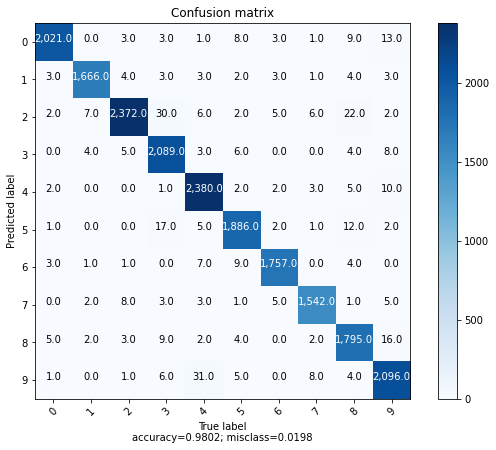

In [27]:
A = forward2(trained_nn, X_test)  #forward
mat = confusion_matrix(A[-1][1], y_test) #confusion_matrix
plot_confusion_matrix(values = mat, classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) 

## Predicción de dígitos encontrados en el medidor.  
Después de realizar la detección sobre el medidor y obtener los dígitos, estos son guardados dentro de la carpeta `results` ordenados conforme se fueron encontrando, en esta sección se obtienen esos archivos y por cada uno se realiza la predicción con la red neuronal entrenada.

Loaded result files ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png']


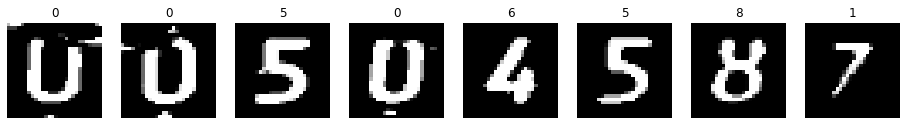

In [20]:
from os import walk

_, _, filenames = next(walk('./results'))
filenames.sort()
print('Loaded result files',filenames)

if filenames:
    fig, axs = plt.subplots(1, len(filenames), figsize=(16, 5))

    for idx, j in enumerate(filenames):
        image = cv2.imread('./results/'+j)
        image = cv2.resize(image,(28, 28))
        axs[idx].axis('off')
        axs[idx].imshow(image.astype(np.uint8))
        # Normalize Image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data = np.asarray(image[:,:,0])
        testi=data/255
        testi = testi.reshape(28 * 28, )
        # Predict and show value
        A = forward2(trained_nn, testi)
        axs[idx].set_title(predict(A[-1][1])[0])
        img += 1



## Método random grid search
Se utilizo una técnica recomendada que indica tomar los híper parámetros de forma aleatoria, de esta forma se pueden probar un rango mas grande de parametros que despues se pueden ir ajustando, despues de cada 5 corridas se guardan dos archivos csv con los resultados.

In [21]:
from datetime import datetime


def random_gird_search(runs = 10, hyperparams = {}):

    alphas = hyperparams['alphas']
    epochs = hyperparams['epochs']
    lmbdas  = hyperparams['lmbdas']
    batch_sizes  = hyperparams['batch_sizes']
    topologies = hyperparams['topologies']
    activations = hyperparams['activations']
    algorithms = hyperparams['algorithms']

    np.random.shuffle(alphas)
    np.random.shuffle(epochs)
    np.random.shuffle(lmbdas)
    np.random.shuffle(batch_sizes)
    np.random.shuffle(topologies)
    np.random.shuffle(algorithms)

    runs_accuracy = []
    runs_latest_cost = []
    used_hyperparams = []

    cont = 0

    for r in range(0, runs):
        np.random.seed()
        randomActivation = np.random.randint(0, 2)
        randomAlgorithm = 0 # np.random.randint(0, 2)
        randomTopology = np.random.randint(0, len(topologies)) 
        randomAlphas = np.random.randint(0, len(alphas)) 
        randomEpochs = np.random.randint(0, len(epochs)) 
        randomLmbdas = np.random.randint(0, len(lmbdas)) 
        randomBatches = np.random.randint(0, len(batch_sizes)) 
        print(randomTopology, randomAlphas, randomEpochs, randomLmbdas, randomBatches)

        (X_train, X_test, y_train, y_test), images, labels = getDataset()
        start = time.time()
        # if algorithms[randomAlgorithm] == 'SGD_batch':
        trained_nn, J = SGD_batch(topologies[randomTopology], activations[randomActivation], X_train, y_train, alphas[randomAlphas], lmbdas[randomLmbdas], epochs[randomEpochs], batch_sizes[randomBatches])
        # else:
        #     trained_nn, J = train(topologies[randomTopology], activations[randomActivation], X_train, y_train, alphas[randomAlphas], lmbdas[randomLmbdas], epochs[randomEpochs])
        end = time.time()
        print('Elapsed time', (end - start)/60, 'minutes')
        runs_latest_cost.append(J[epochs[randomEpochs] - 1])
        A = forward2(trained_nn, X_train)
        acc = accuracy(A[-1][1], y_train)
        runs_accuracy.append(acc)
        used_hyperparams.append((topologies[randomTopology], activations[randomActivation], alphas[randomAlphas], lmbdas[randomLmbdas], epochs[randomEpochs], batch_sizes[randomBatches]))
        print('Accuracy', acc)
        print('Run .No', r)

        if cont == 5:
            cont = 0
            now = datetime.now()
            timestamp = datetime.timestamp(now)
            pd.DataFrame(runs_accuracy).to_csv("./grid-search-results/accuracies-" + str(timestamp) +  ".csv")
            pd.DataFrame(used_hyperparams).to_csv("./grid-search-results/used_hypers-" + str(timestamp) + ".csv")
            continue
        
        cont += 1

    return runs_accuracy, used_hyperparams



## Primera iteracion de una función para generar topologías aleatorias
Al principio se intento generar topologías con capas ocultas aleatorias, el problema con esto fue que tenían muy poca precisión y tomaban mucho tiempo en procesarse, por lo que se opto por declarar 3 topologias principales para que fueran elegidas aleatoriamente.

In [22]:
def getRandomTopologies(x, k, size):
    topologies = []
    for s in range(0, size):
        np.random.seed()
        
        if np.random.randint(0,2) == 1:
            s = np.random.randint(12, 14)
            a = np.random.randint(10, 12)
            tmp = np.arange(a, s, 3)
            tmp = np.insert(tmp, 0, x.shape[1], axis=0)
            tmp = np.insert(tmp, len(tmp), k, axis=0)
            topologies.append(tmp)
        else:
            tmp = np.array([x.shape[1], k])
            topologies.append(tmp)
        

    return np.array(topologies, dtype=object)
print(getRandomTopologies(X_train, 10, 10))


[array([784,  11,  10]) array([784,  10]) array([784,  10])
 array([784,  10]) array([784,  11,  10]) array([784,  10,  10])
 array([784,  10]) array([784,  10,  10]) array([784,  10])
 array([784,  11,  10])]


## Random Grid Search
Aquí se fueron intentando una variedad de rangos para los híper parámetros, utilizando al principio las 3 funciones de activación y los dos algoritmos, pero poco a poco fui viendo que `SGD_batch` era mucho mas rapido y preciso por lo que me enfoque en encontrar los mejores parámetros solo para ese algoritmo, paso lo mismo con las funciones de activacion, las que daban mejor resultado fueron `tanh` y `relu` por lo que deje de intentar con `softmax`.

In [1]:

runs = 200
# getRandomTopologies(X_train, 10, 50)
hyperparams = {
    'alphas': np.arange(0.01, 3, 0.01),
    'epochs': np.arange(10, 50, 10),
    'lmbdas': np.arange(0.1, 3, 0.1),
    'batch_sizes': np.arange(10, 100, 10),
    'topologies': np.array([[784, 30, 10], [784, 100, 10], [784, 60, 10]]),
    'activations': ['tanh', 'relu'],
    'algorithms': ['SGD_batch']
}

# Uncomment only if you have free time
# accuracies, used_hypers = random_gird_search(runs, hyperparams)

NameError: name 'np' is not defined

## Combinación de resultados
En esta sección junto los datasets de la precisión y los parámetros utilizados en un solo dataframe, para después ordenarlo por los que tienen mejor precisión y así poder observar los híper parámetros que se utilizaron.

In [3]:
accuracies_1_df = pd.read_csv('./grid-search-results/accuracies-1620422914.159458.csv', index_col=0)
accuracies_2_df = pd.read_csv('./grid-search-results/accuracies-1620447350.21471.csv', index_col=0)
accuracies_3_df = pd.read_csv('./grid-search-results/accuracies-1620515065.929759.csv', index_col=0)

params_1_df = pd.read_csv('./grid-search-results/used_hypers-1620422914.159458.csv', index_col=0)
params_2_df = pd.read_csv('./grid-search-results/used_hypers-1620447350.21471.csv', index_col=0)
params_3_df = pd.read_csv('./grid-search-results/used_hypers-1620515065.929759.csv', index_col=0)

columns = ['Accuracy', 'Topology', 'Activation', 'Alpha', 'Lambda', 'Epochs', 'Batch Size']


tmp1 = pd.concat([accuracies_1_df, params_1_df], axis=1)
tmp2 = pd.concat([accuracies_2_df, params_2_df], axis=1)
tmp3 = pd.concat([accuracies_3_df, params_3_df], axis=1)

grid_search_results = pd.concat([tmp1, tmp2, tmp3])
grid_search_results.columns = columns

grid_search_results = grid_search_results.sort_values(by=['Accuracy'], ascending=False)
grid_search_results.to_csv('./grid-search-results/grid_search_results.csv')
grid_search_results.head(20)


,Accuracy,Topology,Activation,Alpha,Lambda,Epochs,Batch Size
24,0.987767,[784 60 10],relu,0.03,0.1,60,90
18,0.980317,[784 60 10],tanh,0.24,0.1,60,60
184,0.977544,[784 30 10],relu,0.06,0.1,10,80
60,0.977211,[784 100 10],tanh,0.69,0.1,50,70
7,0.973522,[784 30 10],relu,0.39,0.1,10,70
44,0.973206,[784 30 10],tanh,0.59,0.1,40,90
111,0.971694,[784 30 10],tanh,0.45,0.1,10,80
3,0.970694,[784 100 10],relu,0.60,0.2,20,80
5,0.965589,[784 100 10],relu,0.32,0.4,20,90
188,0.964967,[784 30 10],tanh,0.16,0.1,40,40
